# Autoencoder, the beginning!
### This notebook gives an overview of the actual encoding and decoding visual piece at the end with explanation to show you what's going on and help you understand the material!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn

from models.Autoencoder import Autoencoder
from torchvision import datasets, transforms
from scipy.stats import norm

In [2]:
bs = 4
test_ds = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)
test_dl = t.utils.data.DataLoader(dataset=test_ds, batch_size=bs, shuffle=False, drop_last=True)

In [3]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
model = Autoencoder(test_ds[0][0][None], in_c=1, enc_out_c=[32, 64, 64, 64],
                    enc_ks=[3, 3, 3, 3], enc_pads=[1, 1, 0, 1], enc_strides=[1, 2, 2, 1],
                    dec_out_c=[64, 64, 32, 1], dec_ks=[3, 3, 3, 3], dec_strides=[1, 2, 2, 1],
                    dec_pads=[1, 0, 1, 1], dec_op_pads=[0, 1, 1, 0], z_dim=2)
model.cuda(device)
model.load_state_dict(t.load('03_01.pth'))
model.eval()

Autoencoder(
  (enc_conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.25, inplace=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=

In [4]:
t.set_grad_enabled(False)

In [5]:
examples = next(iter(test_dl))

In [6]:
examples[0][0].shape, examples[1][0], len(examples), len(examples[0]), len(examples[1])

(torch.Size([1, 28, 28]), tensor(7), 2, 4, 4)

In [7]:
x, y = examples[0], examples[1]
x.shape, y.shape

(torch.Size([4, 1, 28, 28]), torch.Size([4]))

In [8]:
encoder = model.enc_conv_layers
decoder = model.dec_conv_layers

In [9]:
z_points = encoder(examples[0].to(device))
reconst_imgs = decoder(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

<Figure size 1080x216 with 0 Axes>

In [10]:
for i in range(bs):
    img = x[i].squeeze()
    ax = fig.add_subplot(2, bs, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i].cpu(), 1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


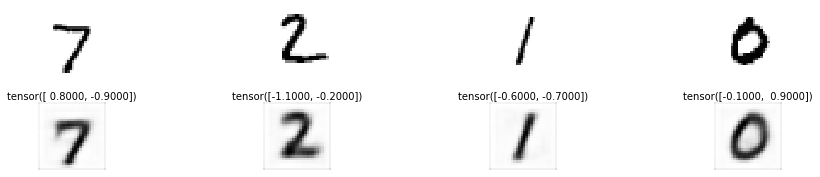

In [11]:
fig

## Mr N. Coder's wall

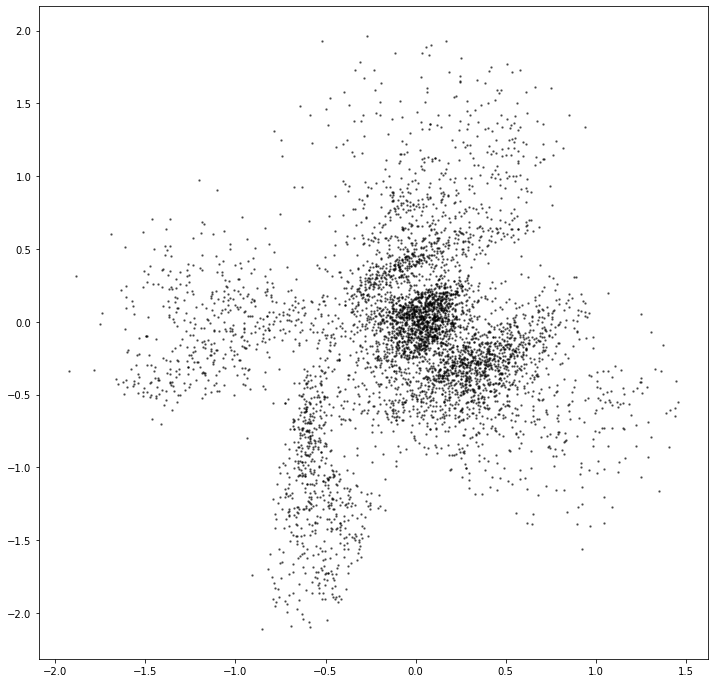

In [12]:
test_dl = t.utils.data.DataLoader(dataset=test_ds, batch_size=5000, shuffle=False, drop_last=True)
examples = next(iter(test_dl))
grid_size = 15
figsize = 12

x, y = examples[0], examples[1]
z_points = encoder(x.to(device)).cpu()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

### Let's see how well our Autoencoder did, by seeing if it decodes the correct numbers! Pay attention to the color map. It represents the colors of the number the encoded space should represent once it's been decoded!

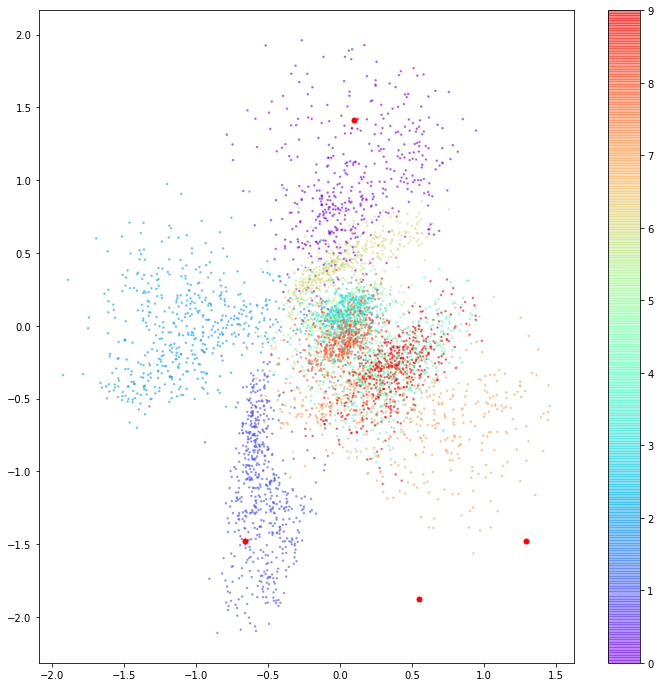

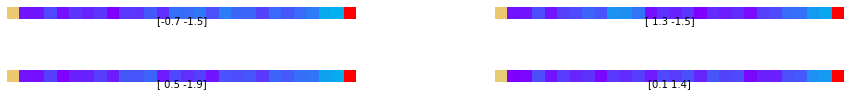

In [13]:
figsize = 12
np.random.seed(42)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

examples = next(iter(test_dl))
x, y = examples[0], examples[1]
z_points = encoder(x.to(device)).cpu()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=y, alpha=0.5, s=2)
plt.colorbar()

grid_size = 2
grid_depth = 2
figsize = 15

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = decoder(t.from_numpy(z_grid).float().to(device)).cpu()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=25)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)    
    ax.imshow(reconst[i, :,:,0], cmap = 'rainbow')

### It seems to me like [-.7, -1.5] should be decoded to 1 because it lies within the blue-purple ranges
### [1.3, -1.5] and [0.5, -1.9] should be decoded to 7 because it lies mostly within the orange ranges
### [0.1, 1.4] should be decoded to 0, because it lies within the purple ranges

## Let's see if it does!

[-0.7 -1.5]		   [ 1.3 -1.5]		   [ 0.5 -1.9]		   [0.1 1.4]		   

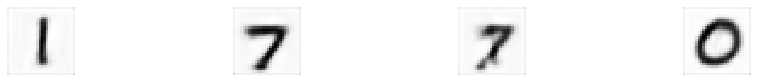

In [14]:
z_points = t.tensor([[-.7, -1.5], [1.3, -1.5], [.5, -1.9], [0.1, 1.4]])
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t\t   ')
    
for i in range(4):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


# And indeed they do! However, please pay attention to the [0.5, -1.9] because we will come back to it in 03_03_autoencoder_analysis. Notice that it doesn't look all that well of a 7. Just a sneakpeek, this is because it is kind of an outlier from the rest of the 7s and others